# Training Trails Notebook

This notebook contains all the code for training the models and hyperparameter tuning. It is split into different sections for different models.

In [1]:
# Import required libraries

# Libraries for data manipulation
import numpy as np
import pandas as pd

# Libraries for data visualization
%matplotlib inline
import matplotlib.pyplot as plt

# Libraries for model training and evaluation
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor

# Libraries for importing metrics
from sklearn.metrics import root_mean_squared_error

# change the directory to the root of the project
import os
os.chdir('../')
from src.utils.data_ingestion import *

### Importing the dataset

In [2]:
# Download the dataset if it doesnt exist
download_dataset()
extract_dataset()

INFO:root:Dataset already exists in the data directory.
INFO:root:Extracting dataset...
INFO:root:Dataset extracted successfully.


In [3]:
data = pd.read_csv("../data/Dataset/Train.csv")
data.head()

,Date,Category,Brand,Day_of_Week,Holiday_Indicator,Past_Purchase_Trends,Price,Discount,Competitor_Price,Sales_Quantity
0,26/09/24,Automotive,BrandA,3,0,17.9,462.30,33.96,359.45,227.0
1,26/09/24,Automotive,BrandA,3,0,66.3,321.28,24.76,49.47,370.0
2,26/09/24,Automotive,BrandA,3,0,14.4,74.85,32.19,245.11,299.0
3,26/09/24,Automotive,BrandA,3,0,34.7,469.12,43.68,144.08,426.0
4,22/09/24,Automotive,BrandA,6,1,93.5,221.76,36.79,478.07,470.0


In [4]:
# Drop the rows having missing values
data.dropna(inplace=True)

## Date Preprocessing

In [5]:
data.head()

,Date,Category,Brand,Day_of_Week,Holiday_Indicator,Past_Purchase_Trends,Price,Discount,Competitor_Price,Sales_Quantity
0,26/09/24,Automotive,BrandA,3,0,17.9,462.30,33.96,359.45,227.0
1,26/09/24,Automotive,BrandA,3,0,66.3,321.28,24.76,49.47,370.0
2,26/09/24,Automotive,BrandA,3,0,14.4,74.85,32.19,245.11,299.0
3,26/09/24,Automotive,BrandA,3,0,34.7,469.12,43.68,144.08,426.0
4,22/09/24,Automotive,BrandA,6,1,93.5,221.76,36.79,478.07,470.0


In [6]:
# convert the date to datetime format and set as index
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)

C:\Users\amuly\AppData\Local\Temp\ipykernel_20420\3682652632.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data['Date'] = pd.to_datetime(data['Date'])


## Date Preprocessing

In [7]:
# Split the data into features and labels
X = data.drop("Sales_Quantity", axis=1)
y = data['Sales_Quantity']

In [8]:
X.head()

,Category,Brand,Day_of_Week,Holiday_Indicator,Past_Purchase_Trends,Price,Discount,Competitor_Price
Date,,,,,,,,
2024-09-26,Automotive,BrandA,3,0,17.9,462.30,33.96,359.45
2024-09-26,Automotive,BrandA,3,0,66.3,321.28,24.76,49.47
2024-09-26,Automotive,BrandA,3,0,14.4,74.85,32.19,245.11
2024-09-26,Automotive,BrandA,3,0,34.7,469.12,43.68,144.08
2024-09-22,Automotive,BrandA,6,1,93.5,221.76,36.79,478.07


In [9]:
y.head()

Date
2024-09-26    227.0
2024-09-26    370.0
2024-09-26    299.0
2024-09-26    426.0
2024-09-22    470.0
Name: Sales_Quantity, dtype: float64

In [10]:
split_size = int(0.8 * len(data))
X_train, y_train = X[:split_size], y[:split_size]
X_val, y_val = X[split_size:], y[split_size:]

In [11]:
# Get the shapes of train and val splits
X_train.shape, y_train.shape, X_val.shape, y_val.shape

((14415, 8), (14415,), (3604, 8), (3604,))

In [12]:
X_train

,Category,Brand,Day_of_Week,Holiday_Indicator,Past_Purchase_Trends,Price,Discount,Competitor_Price
Date,,,,,,,,
2024-09-26,Automotive,BrandA,3,0,17.9,462.30,33.96,359.45
2024-09-26,Automotive,BrandA,3,0,66.3,321.28,24.76,49.47
2024-09-26,Automotive,BrandA,3,0,14.4,74.85,32.19,245.11
2024-09-26,Automotive,BrandA,3,0,34.7,469.12,43.68,144.08
2024-09-22,Automotive,BrandA,6,1,93.5,221.76,36.79,478.07
...,...,...,...,...,...,...,...,...
2023-07-22,Sports,BrandC,5,0,88.9,296.15,36.04,49.93
2023-07-18,Sports,BrandC,1,0,23.4,327.18,23.17,387.47
2023-07-18,Sports,BrandC,1,0,73.1,92.47,37.18,282.88


#### Preprocessor Pipeline

In [13]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

In [14]:
# Define numerical transformer
numerical_transformer = Pipeline(
    steps = [
        ('scaler', StandardScaler())
    ]
)

categorical_transformer = Pipeline(
    steps = [
        ('one_hot_encoder',OneHotEncoder(handle_unknown='ignore', sparse_output=False))
    ]
)

num_columns = list(X.select_dtypes(include=["number"]).columns)
cat_columns = list(X.select_dtypes(exclude=["number"]).columns)

preprocessor = ColumnTransformer(
    transformers = [
        ('num_transformer', numerical_transformer, num_columns),
        ('cat_transformer', categorical_transformer, cat_columns)
    ]
)

In [15]:
num_columns, cat_columns

(['Day_of_Week',
  'Holiday_Indicator',
  'Past_Purchase_Trends',
  'Price',
  'Discount',
  'Competitor_Price'],
 ['Category', 'Brand'])

In [16]:
# Transform the data
X_train_transformed = np.array(preprocessor.fit_transform(X_train))
X_val_transformed = np.array(preprocessor.transform(X_val))
y_train = np.array(y_train)
y_val = np.array(y_val)

In [17]:
# Transform the data for cross validation
X_transformed = np.array(preprocessor.transform(X))

## Modelling

In [18]:
from sklearn.model_selection import cross_val_score

### Machine Learning Models with Hyperparameter Tuning

1. Random Foreast
2. XGBoost
3. LightGBM

#### Random Forest Model

In [19]:
# define the objective function for hyperparameter tuning
rf = RandomForestRegressor(random_state=42)

# Fit the model
rf_score = cross_val_score(rf, X_transformed, y, n_jobs=-1, cv=3, scoring='neg_root_mean_squared_error' ).mean()

rf_score

-144.0890453456221

#### XGBoost Model

In [20]:
# Fit the model
xgb = XGBRegressor(n_estimators=100, random_state=42)

# Fit the model
xgb_score = cross_val_score(xgb, X_transformed, y, n_jobs=-1, cv=3, scoring='neg_root_mean_squared_error' ).mean()

xgb_score

-149.63561060574963

#### LightGBM Model

In [21]:
# Fit the model
lgb = LGBMRegressor(n_estimators=100, random_state=42)

# Fit the model
lgb_score = cross_val_score(lgb, X_transformed, y, n_jobs=-1, cv=3, scoring='neg_root_mean_squared_error' ).mean()

lgb_score

-142.78576318451155

In [22]:
# Create a dataframe to store the results

results_df = pd.DataFrame({
    'Model': ['Random Forest', 'XGBoost', 'LightGBM'],
    'RMSE': [-1 * x for x in [rf_score, xgb_score, lgb_score]] 
})

results_df

,Model,RMSE
0,Random Forest,144.089045
1,XGBoost,149.635611
2,LightGBM,142.785763


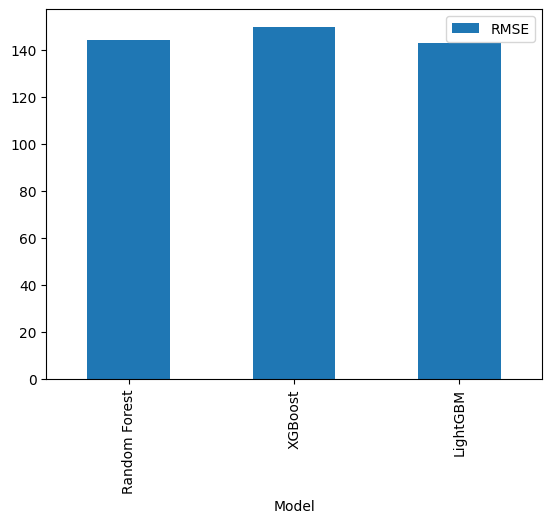

In [23]:
# Plot the results 

results_df.plot(x='Model', y='RMSE', kind='bar')
plt.show()